In [1]:
import numpy as np
# from utils import *
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn.functional as F
import sys
import sklearn
import torch
from scipy.signal import find_peaks
from multiprocessing import Pool
from torch import nn
from matplotlib import rcParams
import matplotlib
from model import Model
config = {"font.family":'Times New Roman', # 设置字体类型"font.size": 15,
#     "mathtext.fontset":'stix',
}
rcParams.update(config)

In [2]:
model = Model()
test_x = np.load('data/X_test.npy')
ppg_signal = test_x
test_x = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))
test_x = torch.FloatTensor(test_x)

test_y = np.load('data/y_seg_test.npy')

model.load_state_dict(torch.load('Save_Model/model_parameter-2023-5-31-1.pkl'))
model.cpu()

Model(
  (depthwise_separable_conv_1): depthwise_separable_conv(
    (depthwise): Conv1d(1, 1, kernel_size=(80,), stride=(1,), padding=(40,), bias=False)
    (pointwise): Conv1d(1, 32, kernel_size=(1,), stride=(1,), bias=False)
    (bn): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (depthwise_separable_conv_2): depthwise_separable_conv(
    (depthwise): Conv1d(32, 32, kernel_size=(40,), stride=(1,), padding=(20,), groups=32, bias=False)
    (pointwise): Conv1d(32, 64, kernel_size=(1,), stride=(1,), bias=False)
    (bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (depthwise_separable_conv_3): depthwise_separable_conv(
    (depthwise): Conv1d(64, 64, kernel_size=(20,), stride=(1,), padding=(10,), groups=64, bias=False)
    (pointwise): Conv1d(64, 128, kernel_size=(1,), stride=(1,), bias=False)
    (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_runn

In [3]:
val_outputs = model(test_x)['seg']
val_outputs = np.array(val_outputs.detach().numpy()).astype(np.int8)
val_outputs[val_outputs <= 0.5] = 0
val_outputs[val_outputs > 0.5] = 1

y_seg_model = val_outputs

val_outputs = val_outputs.flatten() 
val_y = np.array(test_y.flatten()).astype(np.int8)
intersection = np.sum(val_outputs * val_y)
smooth = 0.00001
dice = (2. * intersection + smooth) / (np.sum(val_y) + np.sum(val_outputs) + smooth)
print(dice)

0.42436465138497664


In [4]:
def calc_dice(y_true_flat, y_pred_flat):
    intersection = np.sum(y_pred_flat * y_true_flat)
    smooth = 0.00001
    dice = (2. * intersection + smooth) / (np.sum(y_true_flat) + np.sum(y_pred_flat) + smooth)
    return dice

In [5]:
def get_edges(label):
    label = label.flatten()
    ref = label[1:] - label[:-1]
    base = np.zeros_like(label)
    base[np.where(ref == 1)[0]+1] = 1
    base[np.where(ref == -1)[0]] = 1
    if label[0] == 1:
        base[0] = 1
    if label[-1] == 1:
        base[-1] = 1

    cp_prev = np.concatenate((np.asarray([0]), label[:-1]))
    cp_next = np.concatenate((label[1:], np.asarray([0])))

    cp = cp_prev + cp_next
    cp_base = label - cp

    cp_base[cp_base != 1] = 0
    base[cp_base == 1] = 0

    edges = np.where(base == 1)[0]

    edges = edges.reshape((edges.shape[0] // 2, 2))

    for i in np.where(cp_base == 1)[0]:
        edges = np.concatenate((np.asarray([[i, i]]), edges), axis=0)

    return edges

In [6]:
def plot_on_ax(ppg, label, ax, title='', color='g', overlay=False, label2=None, color2='y'):
    ax.margins(x=0, y=0)
    ax.plot(ppg)
    edges = get_edges(label)
    if len(edges) > 0:
        for edge in edges:
            s, e = edge
            if s == e:
                ax.axvline(x=s, color=color, alpha=0.5)
            else:
                ax.axvspan(xmin=s, xmax=e, facecolor=color, alpha=0.5)
    if overlay:
        edges2 = get_edges(label2)
        if len(edges2) > 0:
            for edge in edges2:
                s, e = edge
                if s == e:
                    ax.axvline(x=s, color=color2, alpha=0.5)
                else:
                    ax.axvspan(xmin=s, xmax=e, facecolor=color2, alpha=0.5)
    ax.set_title(title,fontsize=32)
    ax.tick_params(axis="x", labelsize=28)
    ax.tick_params(axis="y", labelsize=28)
  


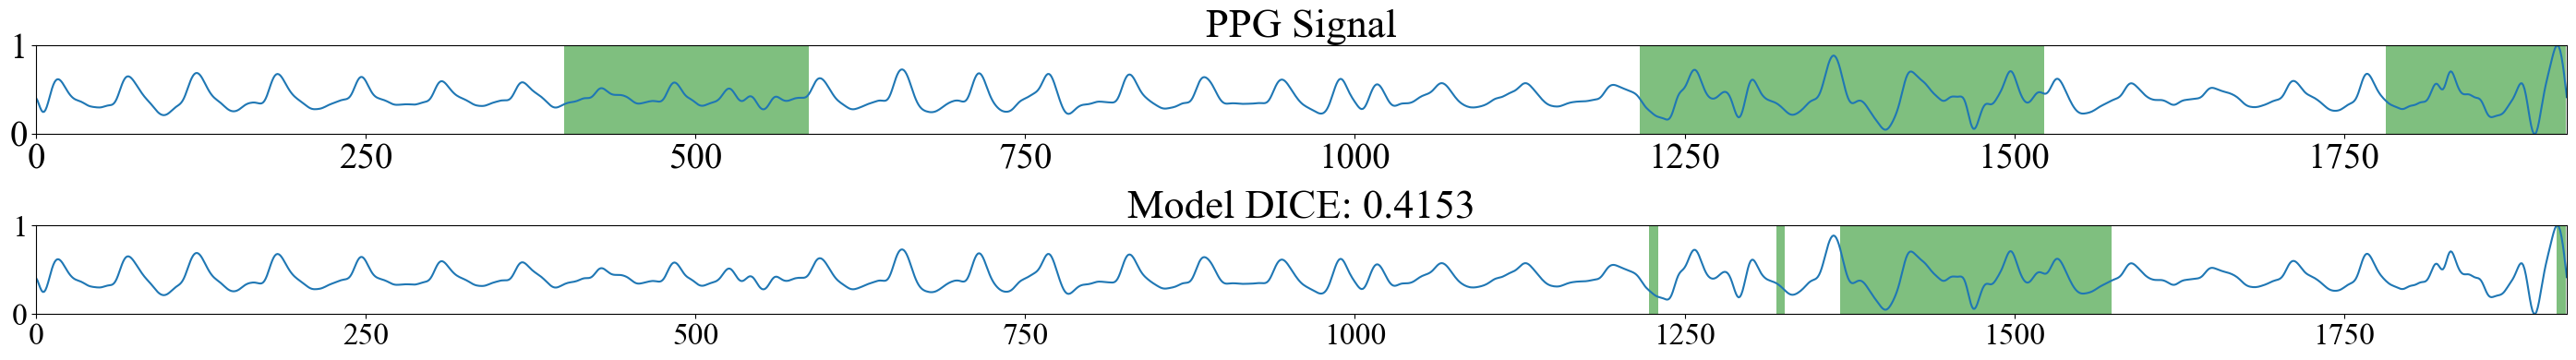

In [7]:
idx=58
TESTSET_NAME = '可视化效果'
ppg = ppg_signal[idx]


y_seg_true = test_y

fig, (ax1,ax2), = plt.subplots(nrows=2, ncols=1, figsize=(28, 4))  #nrows修改图例数目
plot_on_ax(ppg, y_seg_true[idx], title='PPG Signal', overlay=False, ax=ax1)
plot_on_ax(ppg,y_seg_model[idx],
        title='Model' + ' DICE: {}'.format(round(calc_dice(y_seg_true[idx], y_seg_model[idx]), 4)),
        overlay=False, ax=ax2)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.tight_layout()


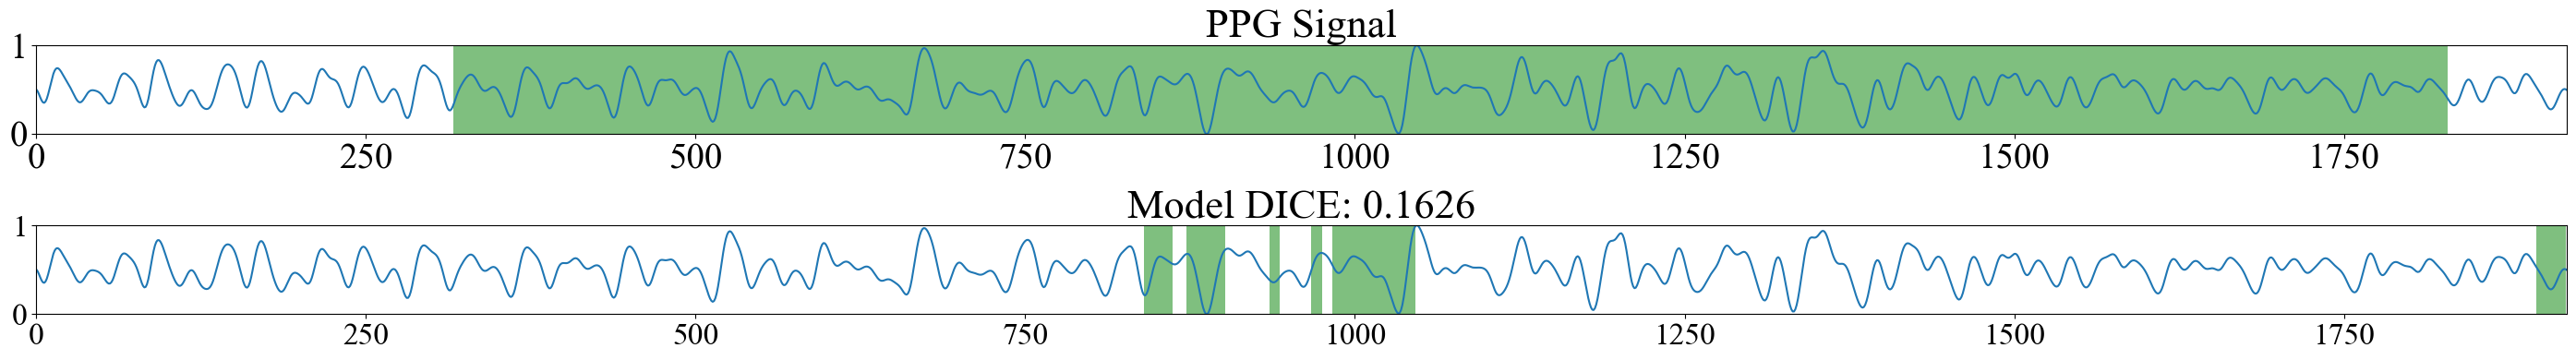

In [19]:
idx=600
TESTSET_NAME = '可视化效果'
ppg = ppg_signal[idx]


y_seg_true = test_y

fig, (ax1,ax2), = plt.subplots(nrows=2, ncols=1, figsize=(28, 4))  #nrows修改图例数目
plot_on_ax(ppg, y_seg_true[idx], title='PPG Signal', overlay=False, ax=ax1)
plot_on_ax(ppg,y_seg_model[idx],
        title='Model' + ' DICE: {}'.format(round(calc_dice(y_seg_true[idx], y_seg_model[idx]), 4)),
        overlay=False, ax=ax2)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.tight_layout()
